In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils import data
from torchvision.transforms import transforms
from torch.utils.data import random_split

#1. Read dataset and create data loaders
#Using transformers to normalise the data, and add augmentation to training images to prevent overfitting (flipping, changing colour, rotating, cropping)
augment_transfomer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32,padding =4),
    transforms.ToTensor(),
    #using mean and standard deviations specific to the CIFAR-10 from https://github.com/kuangliu/pytorch-cifar/issues/19
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))])

testSet_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))])

batch_size = 1024
train_set = torchvision.datasets.CIFAR10(root = './data',train = True, download = True, transform = augment_transfomer)
test_set = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = testSet_transformer)

#DataLoaders
train_loader = data.DataLoader(train_set, batch_size, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:02<00:00, 79.9MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# This file is generated automatically through:
#    d2lbook build lib
# Don't edit it directly

### TAKEN FROM my_utils.py NEURAL NETWORKS AND DEEP LEARNING LAB 3,
### for training script, graphing accuracy and loss, and evalulating model functions
# modifying training script function to use scheduler and GPU device

# Defined in file: ./chapter_preface/index.md
from IPython import display
from matplotlib import pyplot as plt
import pandas as pd
import sys
import time
d2l = sys.modules[__name__]

# Defined in file: ./chapter_preface/index.md
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

def use_svg_display():  #@save
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

# Defined in file: ./chapter_preliminaries/calculus.md
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

# Defined in file: ./chapter_preliminaries/calculus.md
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# Defined in file: ./chapter_preliminaries/calculus.md
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)



# Defined in file: ./chapter_linear-networks/image-classification-dataset.md
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(d2l.numpy(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def accuracy(y_hat, y,device):  #@save
    y_hat, y = y_hat.to(device), y.to(device)
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def evaluate_accuracy(net, data_iter, device):  #@save
    """Compute the accuracy for a model on a dataset."""
    net.to(device)
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y, device), d2l.size(y))
    return metric[0] / metric[1]


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train_epoch_ch3(net, train_iter, loss, updater,device):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.to(device)
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y, device),
                       y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y, device), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, scheduler, device):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    net.to(device)
    for epoch in range(num_epochs):
        net.to(device)

        train_metrics = train_epoch_ch3(net, train_iter, loss, updater, device)
        scheduler.step()
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])


# Defined in file: ./chapter_multilayer-perceptrons/underfit-overfit.md
def evaluate_loss(net, data_iter, loss, device):  #@save
    net.to(device)

    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        l = loss(net(X), y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

ones = torch.ones
zeros = torch.zeros
tensor = torch.tensor
arange = torch.arange
meshgrid = torch.meshgrid
sin = torch.sin
sinh = torch.sinh
cos = torch.cos
cosh = torch.cosh
tanh = torch.tanh
linspace = torch.linspace
exp = torch.exp
log = torch.log
normal = torch.normal
matmul = torch.matmul
int32 = torch.int32
float32 = torch.float32
concat = torch.cat
stack = torch.stack
abs = torch.abs
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

In [ ]:
#2. Creating the model
import torch
import torch.nn as nn

#The STEM - 2 convolutional layers with Relu Activation, then Average pooling reducing dimenstions by half
class Stem(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Stem, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels, 12, kernel_size=3, stride=1, padding=1)
        self.Conv2 = nn.Conv2d(in_channels=12, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.Relu = nn.ReLU()
        self.AvgPool = nn.AvgPool2d(kernel_size=4, padding=1, stride=2)

    def forward(self, x):
        out = self.Conv1(x)
        out = self.Relu(out)
        out = self.Conv2(out)
        out = self.Relu(out)
        out = self.AvgPool(out)
        return out

#EXPERT BRANCH - used in every block to weight the outputs of each convolutional  layer, takes r and k as parameters
#The input goes through Spatial pooling, flattened, forwarded to FC1 where number of outputs channels=number of inputs/r, Relu Activation,
# FC2 projecting num of outputs channels to K number convulations, then Softmax
class ExpertBranch(nn.Module):
    def __init__(self, num_inputs, r, k):
        super(ExpertBranch, self).__init__()
        #Spatial pooling
        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=1)
        #Flattening
        self.Flatten = nn.Flatten()
        # forwarded to FC1 where number of outputs channels=number of inputs/r,
        self.FC1 = nn.Linear(num_inputs, num_inputs // r)
        self.G = nn.ReLU()
        self.FC2 = nn.Linear(num_inputs // r, k)
        self.SoftMax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.AvgPool(x)
        out = self.Flatten(out)
        out = self.FC1(out)
        out = self.G(out)
        out = self.FC2(out)
        a = self.SoftMax(out)
        return a

#BLOCK - each block has parameters for number of convolutions, number of input and output channels, and r, a boolean to indicate if dimensions should be halved or not
class Block(nn.Module):
  def __init__(self, num_convs, in_channels, out_channels, r, half_dim):
        super(Block, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.Relu= nn.ReLU()
        self.r = r
        self.num_convs = num_convs
        self.half_dim = half_dim
        #Expert branch is instantiated, to create the weightings for each convolution.
        self.ExpertBranch = ExpertBranch(in_channels, r, num_convs)
        #Skip connection is instantiated, to add the input of the block to the output by matching the number of output channels, using a 1x1 convolution
        self.Skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        #For the number of convolutions specified, a convolution layer is applied increasing the no. of channels, followed by a Relu layer, followed by a batch normalisation.
        #in each iteration, no. input channels is updated to the current number of output channels to be used in the next conv
        for i in range(num_convs):
            self.add_module(f'Convl{i}', nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))
            self.add_module(f'Relu{i}', nn.ReLU())
            self.add_module(f'BatchNorm{i}', nn.BatchNorm2d(out_channels))
            in_channels = out_channels
        #average pooling is performed halving the dimensions
        self.AvgPool = nn.AvgPool2d(kernel_size=2, stride=2)

  def forward(self, x):
        #array created to store the output of each convolution in the block
        convolutions = []
        #Generate the weights
        a = self.ExpertBranch(x)
        out = x

        #Loop through each convolution layer applying the Relu and batch normalisation, append the outputs to the convulations array
        for i in range(self.num_convs):
            out = self._modules[f'Convl{i}'](out)
            out = self._modules[f'Relu{i}'](out)
            out = self._modules[f'BatchNorm{i}'](out)
            convolutions.append(out)

        #create Output tensor of 0s initally to store the weighted outputs
        output = torch.zeros_like(convolutions[0])
        #For each convolution, their respective weights from the Expert branch (a) is reshaped to match the dimensions of the convolution output and multiplied, then added to the weighted sum Output Tensor.
        for i in range(self.num_convs):
          output += a[:, i].reshape(-1, 1, 1, 1) * convolutions[i]

        #The skip connection is added to the output, Relu and Avg pooling applied.
        output += self.Skip_connection(x)
        output = self.Relu(output)
        if self.half_dim:
            output = self.AvgPool(output)
        return output

#BACKBONE - creates the blocks, setting the no. of convolutions, input channels, output channels and r, passing the output of each block to the next
class Backbone(nn.Module):
    def __init__(self, in_channels, out_channels, r):
        super(Backbone, self).__init__()
        self.Block1 = Block(num_convs=1, in_channels=in_channels, out_channels=60, r=r, half_dim=False)
        self.Block2 = Block(num_convs=2, in_channels=60, out_channels=100, r=r, half_dim=True)
        self.Block3 = Block(num_convs=2, in_channels=100, out_channels=160, r=r, half_dim=False)
        self.Block4 = Block(num_convs=2, in_channels=160, out_channels=240, r=r, half_dim=True)
        self.Block5 = Block(num_convs=3, in_channels=240, out_channels=340, r=r, half_dim=False)
        self.Block6 = Block(num_convs=3, in_channels=340, out_channels=out_channels, r=r, half_dim=True)

    def forward(self, x):
        out = self.Block1(x)
        out = self.Block2(out)
        out = self.Block3(out)
        out = self.Block4(out)
        out = self.Block5(out)
        out = self.Block6(out)
        return out

#CLASSIFIER - passes the last block's output through an spatial avg pool, flattens it,
#then forwards it through 4 Fully connected layers reducing the number of channels, applying Relu and Dropout each time, final FC reduces it to 10 output channels
class Classifier(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Classifier, self).__init__()
        self.AvgPool = nn.AdaptiveAvgPool2d(2)
        self.Flatten = nn.Flatten()
        self.FC1 = nn.Linear(in_channels * 2 * 2, 800)
        self.Relu = nn.ReLU()
        self.FC2 = nn.Linear(800, 400)
        self.Dropout = nn.Dropout(p=0.5)
        self.FC3 = nn.Linear(400, 200)
        self.FC4 = nn.Linear(200, out_channels)

    def forward(self, x):
        out = self.AvgPool(x)
        out = self.Flatten(out)
        out = self.FC1(out)
        out = self.Relu(out)
        out = self.Dropout(out)
        out = self.FC2(out)
        out = self.Relu(out)
        out = self.Dropout(out)
        out = self.FC3(out)
        out = self.Relu(out)
        out = self.Dropout(out)
        out = self.FC4(out)
        return out

#MODEL - combines all the components in the model, and passes the output of each component to the next
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Stem = Stem(in_channels=3, out_channels=32)
        self.Backbone = Backbone(in_channels=32, out_channels=460, r=6)
        self.Classifier = Classifier(in_channels=460, out_channels=10)

    def forward(self, x):
        out = self.Stem(x)
        out = self.Backbone(out)
        out = self.Classifier(out)
        return out


In [ ]:
#Checks if gpu is available to be used
import torch

# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")



Using device: cuda


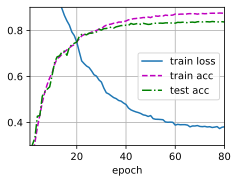

In [ ]:
#3. Create the loss and optimizer
# TAKEN FROM WEEK 8 LAB - Initialises the weights using Xavier
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

#Loss function that combines the softmax activation function and the negative log-likelihood loss
loss = nn.CrossEntropyLoss()
#learning rate, no. epochs hyperparameters
lr = 0.002
epochs = 80

#sending the model to the GPU, and initiliases weights
model = Model().to(device)
model.apply(init_weights)

#Uses Adam to optimise the model parameters and with learning rate lr
optimiser = torch.optim.Adam(model.parameters(), lr)
#Uses StepLR scheduler to half the learning rate every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.5)

#Calls the modified train_ch3 function from my_utils.py to train the model over all the epochs, passing in all the paramaters
train_ch3(model, train_loader, test_loader, loss, epochs , optimiser, scheduler,device)


In [ ]:
test_acc = evaluate_accuracy(model, test_loader,device)
print(test_acc)

0.8365
